# Predict New Groups

In Bambi, it is possible to perform predictions on new, unseen, groups of data that were not in the observed data used to fit the model with the argument `sample_new_groups` in the `model.predict()` method. This is useful in the context of hierarchical modeling, where groups are assumed to be a sample from a larger group. 

Below, it is first described how predictions at multiple levels and for unseen groups are possible with hierarchical models. Then, it is described how this is performed in Bambi. Lastly, a hierarchical model is developed to show how to use the `sample_new_groups` argument in the `model.predict()` method, and within the `interpret` sub-package. For users coming from `brms` in R, this is equivalent to the `sample_new_levels` argument.

## Hierarchical models and predictions at multiple levels

A feature of hierarchical models is that they are able to make predictions at multiple levels. For example, if we were to use the penguin [dataset](https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris) to fit a hierchical regression to estimate the body mass of each penguin species given a set of predictors, we could estimate the mass of all penguins **and** each individual species at the same time. Thus, in this example, there are predictions for two levels: (1) the population level, and (2) the species level.

Additionally, a hierarchical model can be used to make predictions for groups (levels) that were never seen before if a hyperprior is defined over the group-specific effect. With a hyperior defined on group-specific effects, the groups do not share one fixed parameter, but rather share a hyperprior distribution which describes the distribution for the parameter of the prior itself. Lets write a hierarchical model (without intercepts) with a hyperprior defined for group-specific effects in statistical notation so this concept becomes more clear:

$$\beta_{\mu h} \sim \mathcal{N}(0, 10)$$
$$\beta_{\sigma h} \sim \mathcal{HN}(10)$$
$$\beta_{m} \sim \mathcal{N}(\beta_{\mu h}, \beta_{\sigma h})$$
$$\sigma_{h} \sim \mathcal{HN}(10)$$
$$\sigma_{m} \sim \mathcal{HN}(\sigma_{h})$$
$$Y \sim \mathcal{N}(\beta_{m} * X_{m}, \sigma_{m})$$

The parameters $\beta_{\mu h}, \beta_{\sigma h}$ of the group-specific effect prior $\beta_{m}$ come from hyperprior distributions. Thus, if we would like to make predictions for a new, unseen, group, we can do so by first sampling from these hyperprior distributions to obtain the parameters for the new group, and then sample from the posterior or posterior predictive distribution to obtain the estimates for the new group. For a more in depth explanation of hierarchical models in Bambi, see either: the [radon example](https://bambinos.github.io/bambi/notebooks/radon_example.html#varying-intercept-and-slope-model), or the [sleep study example](https://bambinos.github.io/bambi/notebooks/sleepstudy.html).

## Sampling new groups in Bambi

If data with unseen groups are passed to the `new_data` argument of the `model.predict()` method, Bambi first needs to identify if that group exists, and if not, to evaluate the new group with the respective group-specific term. This evaluation updates the [design matrix](https://bambinos.github.io/bambi/notebooks/how_bambi_works.html#design-matrix) initially used to fit the model with the new group(s). This is achieved with the `.evaluate_new_data` method in the [formulae](https://github.com/bambinos/formulae) package. 

Once the design matrix has been updated, Bambi can perform predictions on the new, unseen, groups by specifying `sample_new_groups=True` in `model.predict()`. Each posterior sample for the new groups is drawn from the posterior draws of a randomly selected existing group. Since different groups may be selected at each draw, the end result represents the variation across existing groups.

## Hierarchical regression

To demonstrate the `sample_new_groups` argument, we will develop a hierarchical model on the [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression) dataset. Pulmonary fibrosis is a disorder with no known cause and no known cure, created by scarring of the lungs. Using a hierarchical model, the objective is to predict a patient’s severity of decline in lung function. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled by the patient.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings

import bambi as bmb

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### The OSIC pulmonary fibrosis progression dataset

In the dataset, we were provided with a baseline chest computerized tomography (CT) scan and associated clinical information for a set of patients where the columns represent the following

 - `patient`- a unique id for each patient
 - `weeks`- the relative number of weeks pre/post the baseline CT (may be negative)
 - `fvc` - the recorded lung capacity in millilitres (ml)
 - `percent`- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
 - `sex` - male or female
 - `smoking_status` - ex-smoker, never smoked, currently smokes
 - `age` - age of the patient

A patient has an image acquired at time `week = 0` and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured. Below, we randomly sample three patients and plot their FVC measurements over time.

In [2]:
data = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)

data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace("smokingstatus", "smoking_status")
data

,patient,weeks,fvc,percent,age,sex,smoking_status
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [3]:
predictors = ["patient", "weeks", "fvc", "smoking_status"]

le = LabelEncoder()
data["patient"] = le.fit_transform(data["patient"])
data["smoking_status"] = le.fit_transform(data["smoking_status"])

data["weeks"] = (data["weeks"] - data["weeks"].min()) / (
    data["weeks"].max() - data["weeks"].min()
)
data["fvc"] = (data["fvc"] - data["fvc"].min()) / (
    data["fvc"].max() - data["fvc"].min()
)

data = data[predictors]

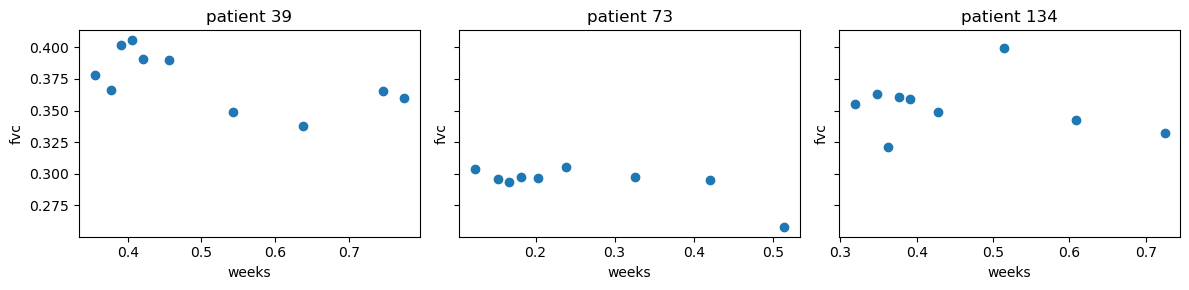

In [4]:
patient_id = data.sample(n=3, random_state=42)["patient"].values

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i, p in enumerate(patient_id):
    patient_data = data[data["patient"] == p]
    ax[i].scatter(patient_data["weeks"], patient_data["fvc"])
    ax[i].set_xlabel("weeks")
    ax[i].set_ylabel("fvc")
    ax[i].set_title(f"patient {p}")

plt.tight_layout()

The plots show variability in FVC measurements, unequal time intervals between follow up visits, and different number of visits per patient. This is a good scenario to use a hierarchical model, where we can model the FVC measurements for each patient as a function of time, and also model the variability in the FVC measurements across patients.

### Partial pooling model

The hierarchical model we will develop is a partially pooled model using the predictors `weeks`, `smoking_status`, and `patient` to predict the response `fvc`. We will estimate the following model with common and group-effects: 
- common-effects: `weeks` and `smoking_status`
- group-effects: the slope of `weeks` will vary by `patient`

Additionally, we will not include the global intercept or an intercept specific for each patient. 

Below, the default prior for the group-effect sigma is changed from `HalfNormal` to a `Gamma` distribution. Additionally, the model graph shows the model has been reparameterized to be non-centered. This is the default when there are group-effects in Bambi.

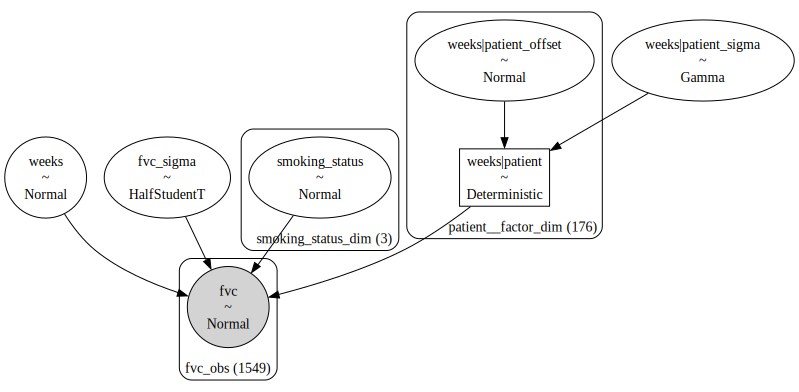

In [52]:
priors = {
    "weeks|patient": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Gamma", alpha=3, beta=3)),
}

model = bmb.Model(
    "fvc ~ 0 + weeks + smoking_status + (0 + weeks | patient)",
    data, 
    priors=priors,
    categorical=["patient", "smoking_status"],
)
model.build()
model.graph()

In [49]:
idata = model.fit(
    draws=1000,
    tune=2500,
    target_accept=0.95,
    chains=4,
    init="auto",
    random_seed=42,
    cores=10,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [fvc_sigma, weeks, smoking_status, weeks|patient_sigma, weeks|patient_offset]


Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 14 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Model criticism

Hierarchical models can induce difficult posterior geometries to sample from. Below, we quickly analyze the traces to ensure sampling went well.

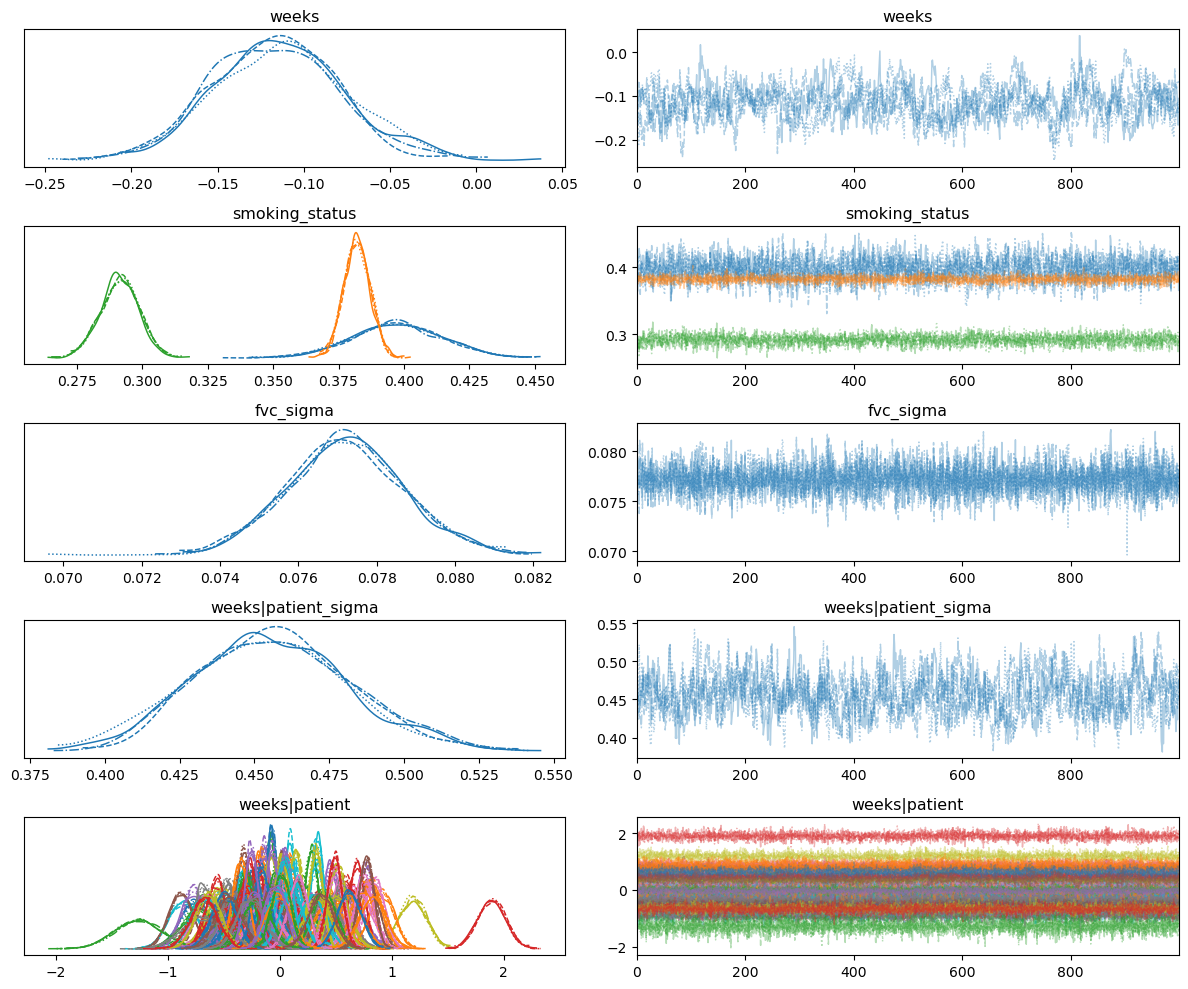

In [50]:
az.plot_trace(idata)
plt.tight_layout();

In [18]:
az.summary(idata, var_names=["weeks", "smoking_status", "fvc_sigma", "weeks|patient_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weeks,-0.115,0.038,-0.187,-0.042,0.002,0.002,238.0,442.0,1.01
smoking_status[0],0.398,0.017,0.366,0.430,0.000,0.000,2168.0,2815.0,1.00
smoking_status[1],0.382,0.005,0.373,0.391,0.000,0.000,2966.0,3141.0,1.00
smoking_status[2],0.291,0.007,0.277,0.305,0.000,0.000,2304.0,3139.0,1.00
fvc_sigma,0.077,0.001,0.074,0.080,0.000,0.000,5846.0,2952.0,1.00
weeks|patient_sigma,0.456,0.026,0.411,0.509,0.001,0.001,432.0,1081.0,1.00


The effective sample size (ESS) is much lower for the `weeks` and `weeks|patient_sigma` parameters. This can also be inferred visually by looking at the trace plots for these parameters above. There seems to be some autocorrelation in the samples for these parameters. However, for the sake of this example, we will not worry about this.

### Predict observed patients

First, we will use the posterior distribution to plot the mean and 95% credible interval for the FVC measurements of the three randomly sampled patients above.

In [19]:
preds = model.predict(idata, kind="mean", inplace=False)
fvc_mean = az.extract(preds["posterior"])["fvc_mean"]

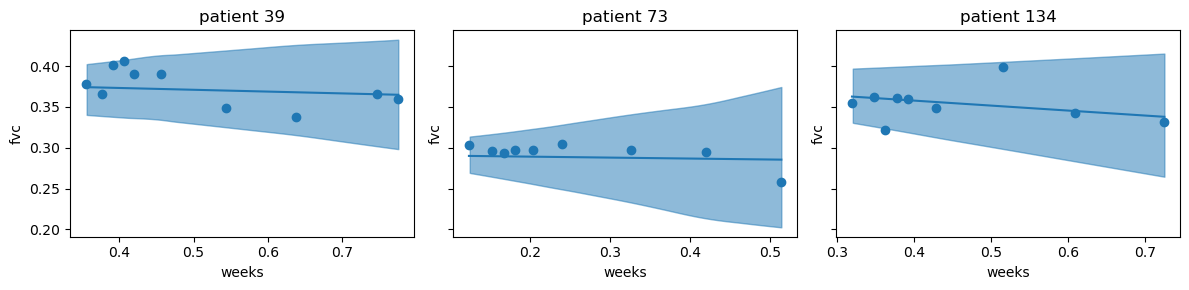

In [20]:
# plot posterior predictions
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i, p in enumerate(patient_id):
    idx = data.index[data["patient"] == p].tolist()
    weeks = data.loc[idx, "weeks"].values
    fvc = data.loc[idx, "fvc"].values

    ax[i].scatter(weeks, fvc)
    az.plot_hdi(weeks, fvc_mean[idx].T, color="C0", ax=ax[i])
    ax[i].plot(weeks, fvc_mean[idx].mean(axis=1), color="C0")

    ax[i].set_xlabel("weeks")
    ax[i].set_ylabel("fvc")
    ax[i].set_title(f"patient {p}")

plt.tight_layout()

The plots show that the posterior estimates seem to fit the three patients well. Where there are more observations, the credible interval is smaller, and where there are fewer observations, the credible interval is larger. Next, we will predict new, unseen, patients.

### Predict new patients

Imagine the cost of acquiring a CT scan increases dramatically, and we would like to interopolate the FVC measurement for a new patient with a given set of clinical information `smokingstatus` and `weeks`. We achieve this by passing this data to the predict method and setting `sample_new_groups=True`. As outlined in the _Sampling new groups in Bambi_ section, this new data is evaluated by `formulae` to update the design matrix, and then predictions are made for the new group by sampling from the posterior draws of a randomly selected existing group.

Below, we will simulate a new patient and predict their FVC measurements over time. First, we will copy clinical data from patient 39 and use it for patient 176 (the new, unseen, patient). Subsequently, we will construct another new patient, with different clinical data.

In [56]:
# copy patient 39 data to the new patient 176
patient_39 = data[data["patient"] == 39].reset_index(drop=True)
new_data = patient_39.copy()
new_data["patient"] = 176
new_data = pd.concat([new_data, patient_39]).reset_index(drop=True)[predictors]
new_data

,patient,weeks,fvc,smoking_status
0,176,0.355072,0.378141,1
1,176,0.376812,0.365937,1
2,176,0.391304,0.401651,1
3,176,0.405797,0.405958,1
4,176,0.420290,0.390883,1
5,176,0.456522,0.390165,1
6,176,0.543478,0.348528,1
7,176,0.637681,0.337581,1
8,176,0.746377,0.365219,1
9,176,0.775362,0.360014,1


In [57]:
preds = model.predict(
    idata, kind="mean",
    data=new_data, 
    sample_new_groups=True,
    inplace=False
)

In [55]:
# utility func for plotting
def plot_new_patient(idata, data, patient_ids):
    fvc_mean = az.extract(idata["posterior"])["fvc_mean"]

    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    for i, p in enumerate(patient_ids):
        idx = data.index[data["patient"] == p].tolist()
        weeks = data.loc[idx, "weeks"].values
        fvc = data.loc[idx, "fvc"].values

        if p == patient_ids[0]:
            ax[i].scatter(weeks, fvc)

        az.plot_hdi(weeks, fvc_mean[idx].T, color="C0", ax=ax[i])
        ax[i].plot(weeks, fvc_mean[idx].mean(axis=1), color="C0")

        ax[i].set_xlabel("weeks")
        ax[i].set_ylabel("fvc")
        ax[i].set_title(f"patient {p}")

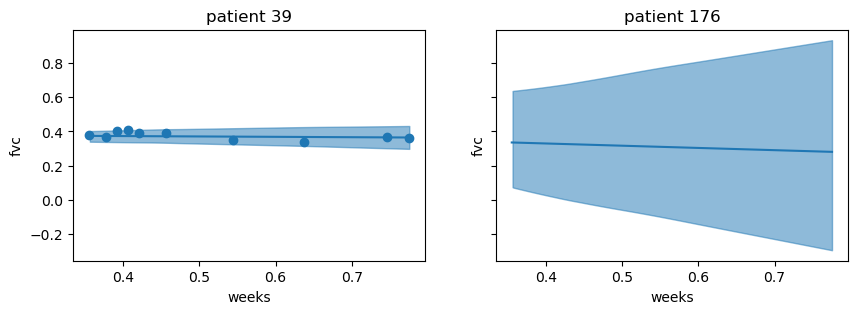

In [58]:
plot_new_patient(preds, new_data, [39, 176])

Although identical data was used for both patients, the variability increased consideribly for patient 176. However, the mean predictions for both patients appear to be almost identical. Now, lets construct a new patient with different clinical data and see how the predictions change. We will select 10 time of follow up visits at random, and set the `smoking_status` to 0 (currently smokes).

In [59]:
new_data.loc[new_data["patient"] == 176, "smoking_status"] = 0
weeks = np.random.choice(sorted(model.data.weeks.unique()), size=10)
new_data.loc[new_data["patient"] == 176, "weeks"] = weeks 
new_data

,patient,weeks,fvc,smoking_status
0,176,0.507246,0.378141,0
1,176,0.326087,0.365937,0
2,176,0.036232,0.401651,0
3,176,0.731884,0.405958,0
4,176,0.811594,0.390883,0
5,176,0.623188,0.390165,0
6,176,0.123188,0.348528,0
7,176,0.659420,0.337581,0
8,176,0.442029,0.365219,0
9,176,0.876812,0.360014,0


If we were to keep the default value of `sample_new_groups=False`, the following error would be raised: `ValueError: There are new groups for the factors ('patient',) and 'sample_new_groups' is False`. Thus, we set `sample_new_groups=True` and obtain predictions for the new patient.

In [60]:
preds = model.predict(
    idata, kind="mean",
    data=new_data, 
    sample_new_groups=True,
    inplace=False
)

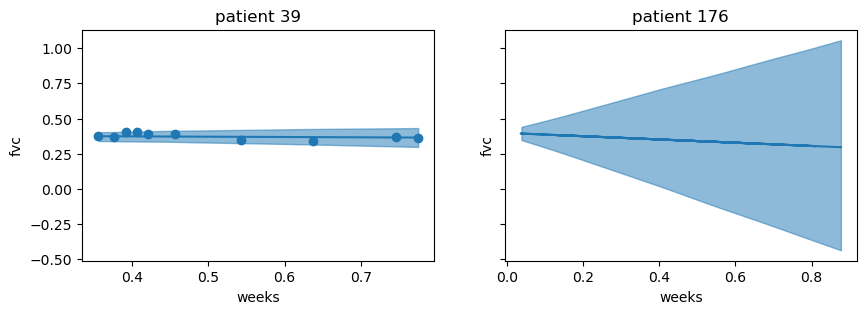

In [61]:
plot_new_patient(preds, new_data, [39, 176])

With `smoking_status = 0`, and the time of follow up visit randomly selected, we can see that the intercept is slightly higher, and it appears that the slope is steeper for this new patient. Again, the variability is much higher for patient 176, and in particular, where there are fewer `fvc` measurements.

#### Predict new patients with `interpret`

The `interpret` sub-package in Bambi allows us to easily interpret the predictions for new patients. In particular, using `bmb.interpret.comparisons`, we can compare the predictions made for a new patient and an existing similar patient. Below, we will compare the predictions made for patient 176 and patient 39. We will use the same clinical data for both patients as we did in the first exampe above.

In [39]:
time_of_follow_up = list(new_data.query("patient == 39")["weeks"].values)
time_of_follow_up

[0.35507246376811596,
 0.37681159420289856,
 0.391304347826087,
 0.4057971014492754,
 0.42028985507246375,
 0.45652173913043476,
 0.5434782608695652,
 0.6376811594202898,
 0.7463768115942029,
 0.7753623188405797]

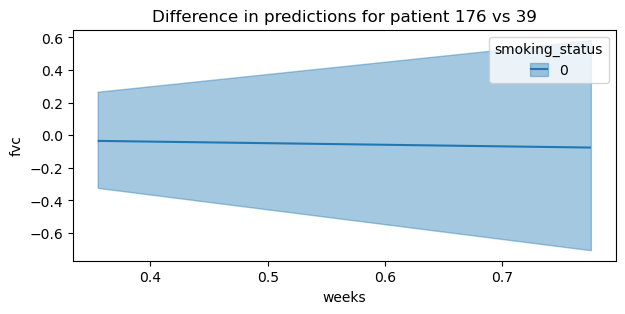

In [40]:
fig, ax = bmb.interpret.plot_comparisons(
    model,
    idata,
    contrast={"patient": [39, 176]},
    conditional={"weeks": time_of_follow_up, "smoking_status": 0},
    sample_new_groups=True,
    fig_kwargs={"figsize": (7, 3)}
)
plt.title("Difference in predictions for patient 176 vs 39");

Referring to the plots where patient 39 and 176 use identical data, the mean `fvc` predictions "look" about the same. When this comparison is made quantitatively using the comparisons function, we can see that mean `fvc` measurements are slightly below 0.0, and have a constant slope across `weeks` indicating there is a slight difference in mean `fvc` measurements between the two patients.

## Summary

In this notebook, it was shown how predictions at multiple levels and for unseen groups are possible with hierarchical models. To utilize this feature of hierarchical models, Bambi first updates the design matrix to include the new group. Then, predictions are made for the new group by sampling from the posterior draws of a randomly selected existing group.

To predict new groups in Bambi, you can either: (1) create a dataset with new groups and pass it to the `model.predict()` method while specifying `sample_new_groups=True`, or (2) use the functions `comparisons` or `slopes` in the `interpret` sub-package with `sample_new_groups=True` to compare predictions or slopes for new groups and existing groups.

In [41]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Oct 07 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.13.2

pandas    : 2.1.0
numpy     : 1.24.2
arviz     : 0.16.1
bambi     : 0.13.0.dev0
matplotlib: 3.7.1

Watermark: 2.3.1

